# Post-Fire Vegetation Recovery: A Decision Support Demonstration

**Purpose**: This notebook demonstrates how simulation modeling can help land managers evaluate post-fire recovery strategies. It is a complete, runnable example of the vegetation modeling component of our post-fire decision support toolbox.

---

## Background: The Post-Fire Decision Problem

After a wildfire, land managers face a critical decision window. They must quickly:

1. **Assess damage** - What burned and how severely?
2. **Predict outcomes** - What will happen if we do nothing? What if we intervene?
3. **Allocate resources** - Where should limited seed, labor, and budget be deployed?

These decisions are complicated by **ecological feedbacks** that can lock landscapes into degraded states:

- Fire kills native trees but temporarily reduces invasive grass cover
- Invasive grasses recover *faster* than native trees
- Once invasives dominate (>50% cover), they block native seedling establishment
- Without intervention, burned areas may flip from native-dominated to invasive-dominated

### Why Simulation?

Traditional approaches to post-fire planning rely on expert judgment or empirical models trained on historical data. But:

- **Experts can't intuit** the outcomes of complex feedbacks over decades
- **Historical data are sparse** for the species and conditions managers care about
- **Novel conditions** (climate change, new invasives) may invalidate past patterns

**Process-based simulation** addresses these limitations by encoding ecological mechanisms (growth rates, mortality, competition) explicitly. The model becomes a "what-if" machine that managers can query: *What happens over 50 years if we plant seedlings here? What if we also remove invasives?*

---

## What This Demonstration Shows

We simulate a **toy ecological system** with:

| Component | Description |
|-----------|-------------|
| **Native Trees** | Individual agents with 3 life stages (seedling, juvenile, adult). Age-dependent mortality, reproduction by adults. |
| **Invasive Grass** | Patch-level cover (0-100%). Grows logistically, suppressed by tree canopy, recovers fast after fire. |
| **Fire** | Spatial severity pattern (0-1). Kills trees based on severity and life stage. Temporarily reduces invasive cover. |
| **Elevation** | N-S gradient (0-100%). High elevation (north) favors native trees; low elevation (south) favors invasives. |
| **Interventions** | Seeding (add native seedlings) and invasive removal (reduce grass cover). |

### Elevation as Ecological Driver

Elevation creates a N-S gradient that **bisects the fire**, making results interpretable:

| Elevation Zone | Location | Native Tree Survival | Invasive Growth | Management Priority |
|----------------|----------|---------------------|-----------------|---------------------|
| **High** (>60%) | NORTH | Good - reduced seedling mortality | Suppressed | Low - natural recovery likely |
| **Medium** (30-60%) | CENTER | Moderate | Moderate | Medium - seeding helps |
| **Low** (<30%) | SOUTH | Poor - seedlings struggle | Thrives | High - removal critical |

The key insight: *"High elevation (northern) burned areas will recover on their own; prioritize management in low elevation (southern) burned areas where invasives would otherwise dominate."*

### Scenarios Compared

| Scenario | Fire? | Seeding? | Removal? | Question Answered |
|----------|-------|----------|----------|-------------------|
| `baseline` | No | No | No | What happens without disturbance? (Control) |
| `fire_only` | Yes | No | No | How bad is fire without intervention? |
| `fire_seeding` | Yes | Yes | No | Does planting seedlings help recovery? |
| `fire_removal` | Yes | No | Yes | Does removing invasives help recovery? |
| `fire_both` | Yes | Yes | Yes | Is the combination better than either alone? |

### Workflow Steps

1. **Setup** - Load libraries, configure paths
2. **Generate Spatial Data** - Create fire severity and elevation rasters (45x45 grid)
3. **Preprocess for Josh** - Convert GeoTIFFs to Josh's optimized format
4. **Validate Model** - Check the simulation model compiles
5. **Run Scenarios** - Execute 5 scenarios (50 years each)
6. **Analyze Results** - Compare outcomes across scenarios

---

## Step 1: Setup and Configuration

**What we're doing**: Loading required Python packages and configuring file paths.

**Why it matters**: Ensures the environment is ready and paths point to the correct files.

In [1]:
# Standard scientific Python stack
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Geospatial: for creating GeoTIFF rasters
import rasterio
from rasterio.transform import from_bounds
from rasterio.crs import CRS

# Image processing: for smoothing noise in fire pattern
from scipy.ndimage import uniform_filter

# System utilities
import os
import glob
import subprocess

# Create output directories (organized structure)
os.makedirs('data', exist_ok=True)
os.makedirs('preprocessed', exist_ok=True)
os.makedirs('results', exist_ok=True)
os.makedirs('analysis/figures/inputs', exist_ok=True)
os.makedirs('analysis/figures/timeseries', exist_ok=True)
os.makedirs('analysis/figures/spatial', exist_ok=True)
os.makedirs('analysis/summaries', exist_ok=True)

print("Environment ready.")

Environment ready.


In [2]:
# =============================================================================
# FILE PATHS
# =============================================================================
# These define where the Josh simulation engine and model files are located.

JOSH_JAR = "jar/joshsim-fat-prod.jar"  # Josh simulation engine (Java)
MODEL_FILE = "vegetation_model.josh"   # The ecological model definition
PARAMS_CONFIG = "configs/params.jshc"  # Shared ecological parameters

# Preprocessed spatial data for Josh
FIRE_DATA = "preprocessed/fire_severity.jshd"
ELEVATION_DATA = "preprocessed/elevation.jshd"

# The five scenarios we'll compare
SCENARIOS = [
    "baseline",      # No fire, no intervention (counterfactual control)
    "fire_only",     # Fire without any management response
    "fire_seeding",  # Fire + plant native seedlings
    "fire_removal",  # Fire + remove invasive grasses
    "fire_both",     # Fire + both interventions combined
]

# Verify the Josh JAR exists
if os.path.exists(JOSH_JAR):
    print(f"Josh simulation engine found: {JOSH_JAR}")
else:
    print(f"ERROR: Josh JAR not found at {JOSH_JAR}")
    print("Please run: bash get_fat_jar.sh")

Josh simulation engine found: jar/joshsim-fat-prod.jar


In [3]:
# =============================================================================
# SPATIAL CONFIGURATION
# =============================================================================
# These parameters define the simulation grid. They must match the Josh model.

N_ROWS = 45  # Number of patches in Y direction (1.5x larger for clearer patterns)
N_COLS = 45  # Number of patches in X direction

# Geographic bounds in WGS84 degrees
# (Using a small synthetic area; actual location doesn't matter for this demo)
LON_LOW, LON_HIGH = 0.0, 0.0045
LAT_LOW, LAT_HIGH = 0.0, 0.0045

# Approximate extent in meters (for visualization labels)
X_LOW, X_HIGH = 0, 450
Y_LOW, Y_HIGH = 0, 450

# GeoTIFF transform (maps pixel coordinates to geographic coordinates)
TRANSFORM = from_bounds(LON_LOW, LAT_LOW, LON_HIGH, LAT_HIGH, N_COLS, N_ROWS)

# Common raster profile for GeoTIFF files
BASE_PROFILE = {
    'driver': 'GTiff',
    'width': N_COLS,
    'height': N_ROWS,
    'count': 1,
    'crs': CRS.from_epsg(4326),  # WGS84
    'transform': TRANSFORM,
}

print(f"Simulation grid: {N_ROWS} x {N_COLS} = {N_ROWS * N_COLS} patches")
print(f"Each patch: ~10m x 10m")
print(f"Total area: ~{(X_HIGH-X_LOW)}m x {(Y_HIGH-Y_LOW)}m")

Simulation grid: 45 x 45 = 2025 patches
Each patch: ~10m x 10m
Total area: ~450m x 450m


---

## Step 2: Generate Spatial Data

### 2a. Fire Severity

**What we're doing**: Creating a synthetic fire severity raster as a **vertical band** that cuts across the N-S elevation gradient.

**Why it matters**: This spatial design is critical for demonstrating the management insight:

```
       WEST          CENTER (FIRE)        EAST
┌──────────────┬─────────────────┬──────────────┐
│              │                 │              │
│   No fire    │  HIGH ELEV +    │   No fire    │  NORTH (high elev)
│              │  FIRE           │              │
│              │  (recovers      │              │
│              │   naturally)    │              │
│              │                 │              │
│              ├─────────────────┤              │
│              │                 │              │
│   No fire    │  LOW ELEV +     │   No fire    │  SOUTH (low elev)
│              │  FIRE           │              │
│              │  (needs         │              │
│              │   intervention) │              │
│              │                 │              │
└──────────────┴─────────────────┴──────────────┘
```

**Severity thresholds in the model:**
- **High severity (>0.7)** in center of band: Most trees killed
- **Moderate severity (0.3-0.7)** at band edges: Patchy survival
- **Low severity (<0.3)** outside band: Most trees survive

The vertical band design ensures that the fire spans ALL elevation zones, enabling the key comparison:
- **Fire + high elevation**: Should recover naturally (no intervention needed)
- **Fire + low elevation**: Needs intervention (invasives would dominate)

In [4]:
def generate_fire_severity(n_rows, n_cols, band_center_x, band_width, max_severity, 
                           noise_scale=0.2, seed=None):
    """
    Generate a fire severity pattern as a VERTICAL BAND that cuts across elevation.
    
    The pattern creates a N-S oriented fire band that intersects the elevation gradient:
    - Northern part of fire = high elevation (should recover naturally)
    - Southern part of fire = low elevation (needs intervention)
    
    This design enables the key management insight:
    "High elevation burned areas recover on their own; prioritize low elevation."
    
    Returns:
        2D array of fire severity values (0-1)
    """
    if seed is not None:
        np.random.seed(seed)
    
    y, x = np.ogrid[:n_rows, :n_cols]
    
    # Create a VERTICAL BAND (runs N-S, centered at band_center_x)
    # Severity is highest at center and decreases toward edges (Gaussian profile in X)
    distance_from_center_x = np.abs(x - band_center_x)
    base_severity = max_severity * np.exp(-distance_from_center_x**2 / (2 * band_width**2))
    
    # Add spatially-correlated noise (smoother than random noise)
    raw_noise = np.random.randn(n_rows, n_cols)
    smooth_noise = uniform_filter(raw_noise, size=5, mode='reflect')
    smooth_noise = smooth_noise / (np.abs(smooth_noise).max() + 1e-10)
    
    # Noise is stronger at fire edges (where conditions are marginal)
    edge_factor = 4 * base_severity * (1 - base_severity)
    noise_contribution = noise_scale * smooth_noise * edge_factor
    
    severity = base_severity + noise_contribution
    severity = np.clip(severity, 0, 1)
    
    return severity.astype(np.float32)

# Generate the fire severity pattern as a VERTICAL BAND
# This ensures fire cuts across the N-S elevation gradient:
# - Northern part of band = high elevation + fire -> recovers naturally
# - Southern part of band = low elevation + fire -> needs intervention
BAND_CENTER_X = N_COLS // 2  # Center of the grid (horizontally)
BAND_WIDTH = 10  # Width of the fire band (in patches)
FIRE_MAX = 0.95  # Peak severity at center of band

fire_severity = generate_fire_severity(
    N_ROWS, N_COLS, BAND_CENTER_X, BAND_WIDTH, FIRE_MAX,
    noise_scale=0.25, seed=42  # Fixed seed for reproducibility
)

# Save as GeoTIFF
fire_profile = BASE_PROFILE.copy()
fire_profile['dtype'] = 'float32'
fire_profile['nodata'] = -9999

with rasterio.open('data/fire_severity.tif', 'w', **fire_profile) as dst:
    dst.write(fire_severity, 1)

# Summary statistics
print("Fire Severity Summary (VERTICAL BAND pattern):")
print(f"  Range: {fire_severity.min():.2f} to {fire_severity.max():.2f}")
print(f"  High severity (>0.7): {(fire_severity > 0.7).sum()} patches ({100*(fire_severity > 0.7).mean():.1f}%)")
print(f"  Moderate (0.3-0.7): {((fire_severity > 0.3) & (fire_severity <= 0.7)).sum()} patches")
print(f"  Low (<0.3): {(fire_severity <= 0.3).sum()} patches")
print(f"\n  Fire is a vertical band cutting across the N-S elevation gradient:")
print(f"    - NORTH part of fire = high elevation (natural recovery)")
print(f"    - SOUTH part of fire = low elevation (needs intervention)")
print(f"\nSaved: data/fire_severity.tif")

Fire Severity Summary (VERTICAL BAND pattern):
  Range: 0.01 to 0.98
  High severity (>0.7): 783 patches (38.7%)
  Moderate (0.3-0.7): 597 patches
  Low (<0.3): 645 patches

  Fire is a vertical band cutting across the N-S elevation gradient:
    - NORTH part of fire = high elevation (natural recovery)
    - SOUTH part of fire = low elevation (needs intervention)

Saved: data/fire_severity.tif


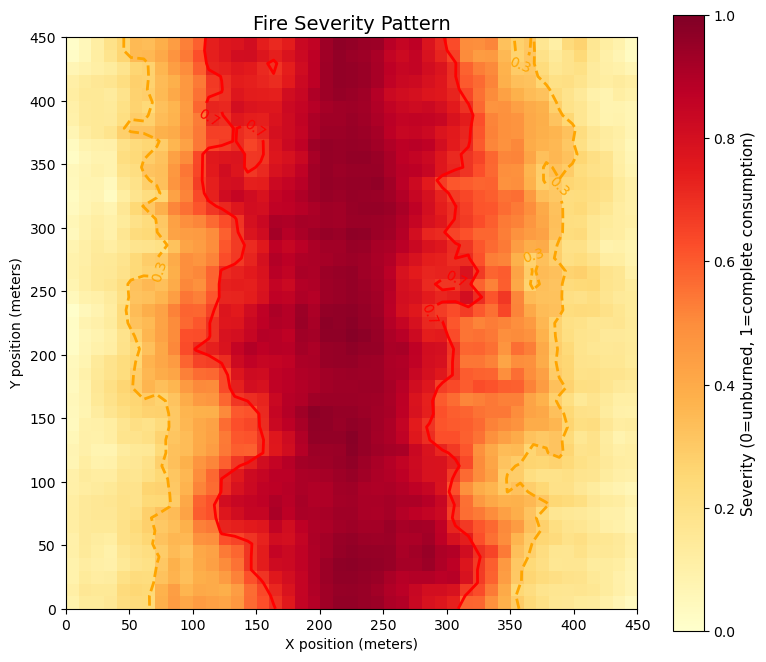


Severity thresholds used in the model:
  - 0.3 (orange dashed): Below this, low fire mortality
  - 0.7 (red solid): Above this, high fire mortality


In [5]:
# Visualize the fire severity pattern
fig, ax = plt.subplots(figsize=(8, 8))

im = ax.imshow(fire_severity, cmap='YlOrRd', vmin=0, vmax=1, origin='lower',
               extent=[X_LOW, X_HIGH, Y_LOW, Y_HIGH])
ax.set_title('Fire Severity Pattern', fontsize=14)
ax.set_xlabel('X position (meters)')
ax.set_ylabel('Y position (meters)')

# Show severity threshold contours
contours = ax.contour(
    np.linspace(X_LOW, X_HIGH, N_COLS), 
    np.linspace(Y_LOW, Y_HIGH, N_ROWS),
    fire_severity, 
    levels=[0.3, 0.7], 
    colors=['orange', 'red'], 
    linestyles=['--', '-'], 
    linewidths=2
)
ax.clabel(contours, inline=True, fontsize=10, fmt='%.1f')

cbar = plt.colorbar(im, ax=ax, shrink=0.8)
cbar.set_label('Severity (0=unburned, 1=complete consumption)', fontsize=11)

plt.tight_layout()
plt.savefig('analysis/figures/inputs/fire_severity_preview.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nSeverity thresholds used in the model:")
print("  - 0.3 (orange dashed): Below this, low fire mortality")
print("  - 0.7 (red solid): Above this, high fire mortality")

### 2b. Elevation Gradient

**What we're doing**: Creating a synthetic elevation raster with a simple N-S (north-south) gradient that **bisects the fire**.

**Why it matters**: Elevation creates spatial structure in ecological outcomes that makes difference maps interpretable. The key design choice is that the gradient runs **through** the fire center, not around it:

- **High elevation (NORTH)**: Native trees recover better (cooler, moister). Invasives are climate-limited.
- **Low elevation (SOUTH)**: Invasive grasses thrive (warmer, drier conditions favor them). Native seedlings struggle with drought stress.
- **Fire CENTER overlaps BOTH zones**: This creates the interpretable pattern we need!

**Spatial design principle**:
```
┌─────────────────────────────────────┐
│     HIGH ELEVATION (NORTH)          │
│           >60%                      │
│─────────────────────────────────────│
│     FIRE + HIGH ELEV                │  ← Fire overlaps high elev
│     (recovers naturally)            │
│ ─ ─ ─ ─ FIRE CENTER ─ ─ ─ ─ ─ ─ ─  │
│     FIRE + LOW ELEV                 │  ← Fire overlaps low elev
│     (needs intervention)            │
│─────────────────────────────────────│
│     LOW ELEVATION (SOUTH)           │
│           <30%                      │
└─────────────────────────────────────┘
```

**Key parameters in `configs/params.jshc`:**
- `invasiveElevationReduction`: How much elevation suppresses invasive growth
- `seedlingElevationReduction`: How much elevation helps seedling survival
- `juvenileElevationReduction`: How much elevation helps juvenile survival

**The insight**: *"High elevation burned areas will recover on their own; prioritize management in low elevation burned areas where invasives would otherwise dominate."*

In [6]:
def generate_elevation(n_rows, n_cols, seed=None):
    """
    Generate a N-S elevation gradient that intersects the fire center.
    
    The pattern creates clear ecological zones that BISECT the fire:
    - NORTH (top): High elevation (trees thrive, invasives suppressed)
    - SOUTH (bottom): Low elevation (invasives thrive, seedlings struggle)
    - CENTER: Fire overlaps BOTH zones, creating interpretable intervention patterns
    
    This design ensures:
    - Part of the burned area is HIGH elevation (will recover naturally)
    - Part of the burned area is LOW elevation (needs intervention)
    
    Parameters:
        n_rows, n_cols: Grid dimensions
        seed: Random seed for reproducibility
        
    Returns:
        2D array of elevation values (0-1 ratio for Josh)
    """
    if seed is not None:
        np.random.seed(seed)
    
    # Create coordinate grids (0-1 normalized)
    y, x = np.ogrid[:n_rows, :n_cols]
    y_norm = y / (n_rows - 1)
    
    # Simple N-S gradient: high at top (north), low at bottom (south)
    # y=0 is bottom (south), y=max is top (north)
    # SCALED TO 0-1 ratio for Josh unit compatibility
    elevation = y_norm  # 0.0 at bottom, 1.0 at top
    
    # Add subtle noise for realism (but keep patterns clear)
    noise = np.random.randn(n_rows, n_cols) * 0.03  # Scaled noise
    elevation = np.clip(elevation + noise, 0, 1)
    
    return elevation.astype(np.float32)

# =============================================================================
# ELEVATION: N-S GRADIENT THROUGH FIRE CENTER
# =============================================================================
# The elevation gradient runs THROUGH the fire (north to south), creating:
#   - Northern part of fire scar: HIGH elevation -> natural recovery
#   - Southern part of fire scar: LOW elevation -> needs intervention
# Elevation is 0-1 ratio to match Josh's unit handling.
# Zone thresholds in the model: >0.6 = high, 0.3-0.6 = medium, <0.3 = low

elevation = generate_elevation(
    N_ROWS, N_COLS, 
    seed=42  # Fixed seed for reproducibility
)

# Save as GeoTIFF
elevation_profile = BASE_PROFILE.copy()
elevation_profile['dtype'] = 'float32'
elevation_profile['nodata'] = -9999

with rasterio.open('data/elevation.tif', 'w', **elevation_profile) as dst:
    dst.write(elevation, 1)

# Summary statistics (0-1 scale, zones defined by model thresholds)
print("Elevation Summary (N-S gradient, 0-1 ratio):")
print(f"  Range: {elevation.min():.2f} to {elevation.max():.2f}")
print(f"  High elevation (>0.6): {(elevation > 0.6).sum()} patches ({100*(elevation > 0.6).mean():.1f}%)")
print(f"  Medium (0.3-0.6): {((elevation > 0.3) & (elevation <= 0.6)).sum()} patches")
print(f"  Low (<0.3): {(elevation <= 0.3).sum()} patches")
print(f"\n  Gradient runs N-S through fire center for interpretable patterns")
print(f"\nSaved: data/elevation.tif")

Elevation Summary (N-S gradient, 0-1 ratio):
  Range: 0.00 to 1.00
  High elevation (>0.6): 813 patches (40.1%)
  Medium (0.3-0.6): 599 patches
  Low (<0.3): 613 patches

  Gradient runs N-S through fire center for interpretable patterns

Saved: data/elevation.tif


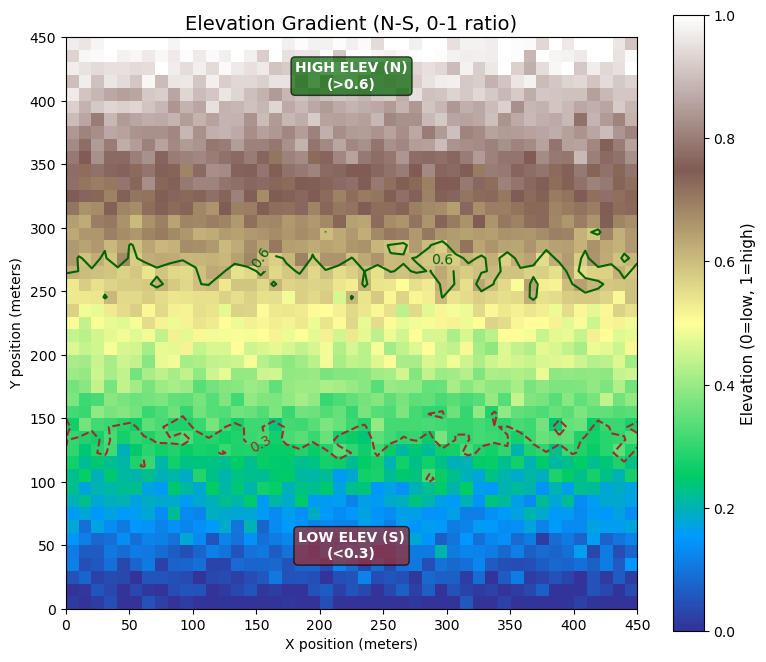


Elevation zones and ecological effects (0-1 ratio):
  - High (>0.6, NORTH): Seedling survival bonus, invasive growth suppressed
  - Medium (0.3-0.6, CENTER): Intermediate conditions (partial bonus)
  - Low (<0.3, SOUTH): Seedlings struggle, invasives thrive

  N-S gradient bisects the fire, enabling interpretable spatial patterns


In [7]:
# Visualize elevation pattern (0-1 scale)
fig, ax = plt.subplots(figsize=(8, 8))

im = ax.imshow(elevation, cmap='terrain', vmin=0, vmax=1, origin='lower',
               extent=[X_LOW, X_HIGH, Y_LOW, Y_HIGH])
ax.set_title('Elevation Gradient (N-S, 0-1 ratio)', fontsize=14)
ax.set_xlabel('X position (meters)')
ax.set_ylabel('Y position (meters)')

# Show elevation zone contours (matching Josh thresholds: 0.3 and 0.6)
contours = ax.contour(
    np.linspace(X_LOW, X_HIGH, N_COLS), 
    np.linspace(Y_LOW, Y_HIGH, N_ROWS),
    elevation, 
    levels=[0.30, 0.60],  # Zone thresholds
    colors=['brown', 'darkgreen'], 
    linestyles=['--', '-'], 
    linewidths=1.5
)
ax.clabel(contours, inline=True, fontsize=10, fmt='%.1f')

cbar = plt.colorbar(im, ax=ax, shrink=0.8)
cbar.set_label('Elevation (0=low, 1=high)', fontsize=11)

# Add annotations for ecological zones - N-S gradient
ax.annotate('HIGH ELEV (N)\n(>0.6)', xy=(X_HIGH/2, Y_HIGH-40), fontsize=10, 
            color='white', fontweight='bold', ha='center',
            bbox=dict(boxstyle='round', facecolor='darkgreen', alpha=0.7))
ax.annotate('LOW ELEV (S)\n(<0.3)', xy=(X_HIGH/2, 40), fontsize=10, 
            color='white', fontweight='bold', ha='center',
            bbox=dict(boxstyle='round', facecolor='brown', alpha=0.7))

plt.tight_layout()
plt.savefig('analysis/figures/inputs/elevation_preview.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nElevation zones and ecological effects (0-1 ratio):")
print("  - High (>0.6, NORTH): Seedling survival bonus, invasive growth suppressed")
print("  - Medium (0.3-0.6, CENTER): Intermediate conditions (partial bonus)")
print("  - Low (<0.3, SOUTH): Seedlings struggle, invasives thrive")
print("\n  N-S gradient bisects the fire, enabling interpretable spatial patterns")

### 2c. Zone Rasters for Josh Compatibility

**What we're doing**: Pre-calculating discrete elevation and fire severity zones.

**Why it matters**: Josh has issues comparing external ratio data (0-1) with literal numbers. By pre-calculating zones as discrete count values (0, 1, 2), we can use reliable `== count` comparisons instead of unreliable `> ratio` comparisons.

| Zone Value | Elevation | Fire Severity |
|------------|-----------|---------------|
| 0 (Low) | < 0.3 | < 0.3 |
| 1 (Medium) | 0.3 - 0.6 | 0.3 - 0.7 |
| 2 (High) | > 0.6 | > 0.7 |

In [8]:
# =============================================================================
# PRE-CALCULATE ZONES FOR JOSH COMPATIBILITY
# =============================================================================
# Josh cannot reliably compare external ratio data with literals (e.g., elevation > 0.6).
# Instead, we pre-calculate discrete zones (0=low, 1=medium, 2=high) as count values.
# Josh can then use == comparisons which work reliably.

# Elevation zones
# 0 = Low (< 0.3), 1 = Medium (0.3-0.6), 2 = High (> 0.6)
elevation_zone = np.zeros_like(elevation, dtype=np.float32)
elevation_zone[elevation >= 0.3] = 1
elevation_zone[elevation >= 0.6] = 2

print("Elevation Zone Summary:")
print(f"  Low (0):    {(elevation_zone == 0).sum()} patches ({100*(elevation_zone == 0).mean():.1f}%)")
print(f"  Medium (1): {(elevation_zone == 1).sum()} patches ({100*(elevation_zone == 1).mean():.1f}%)")
print(f"  High (2):   {(elevation_zone == 2).sum()} patches ({100*(elevation_zone == 2).mean():.1f}%)")

# Fire severity zones
# 0 = Low (< 0.3), 1 = Medium (0.3-0.7), 2 = High (> 0.7)
fire_zone = np.zeros_like(fire_severity, dtype=np.float32)
fire_zone[fire_severity >= 0.3] = 1
fire_zone[fire_severity >= 0.7] = 2

print("\nFire Severity Zone Summary:")
print(f"  Low (0):    {(fire_zone == 0).sum()} patches ({100*(fire_zone == 0).mean():.1f}%)")
print(f"  Medium (1): {(fire_zone == 1).sum()} patches ({100*(fire_zone == 1).mean():.1f}%)")
print(f"  High (2):   {(fire_zone == 2).sum()} patches ({100*(fire_zone == 2).mean():.1f}%)")

# Save zone rasters as GeoTIFFs
zone_profile = BASE_PROFILE.copy()
zone_profile['dtype'] = 'float32'
zone_profile['nodata'] = -9999

with rasterio.open('data/elevation_zone.tif', 'w', **zone_profile) as dst:
    dst.write(elevation_zone, 1)
print("\nSaved: data/elevation_zone.tif")

with rasterio.open('data/fire_zone.tif', 'w', **zone_profile) as dst:
    dst.write(fire_zone, 1)
print("Saved: data/fire_zone.tif")

print("\nThese zone rasters will be preprocessed with 'count' units for Josh.")

Elevation Zone Summary:
  Low (0):    613 patches (30.3%)
  Medium (1): 599 patches (29.6%)
  High (2):   813 patches (40.1%)

Fire Severity Zone Summary:
  Low (0):    645 patches (31.9%)
  Medium (1): 597 patches (29.5%)
  High (2):   783 patches (38.7%)

Saved: data/elevation_zone.tif
Saved: data/fire_zone.tif

These zone rasters will be preprocessed with 'count' units for Josh.


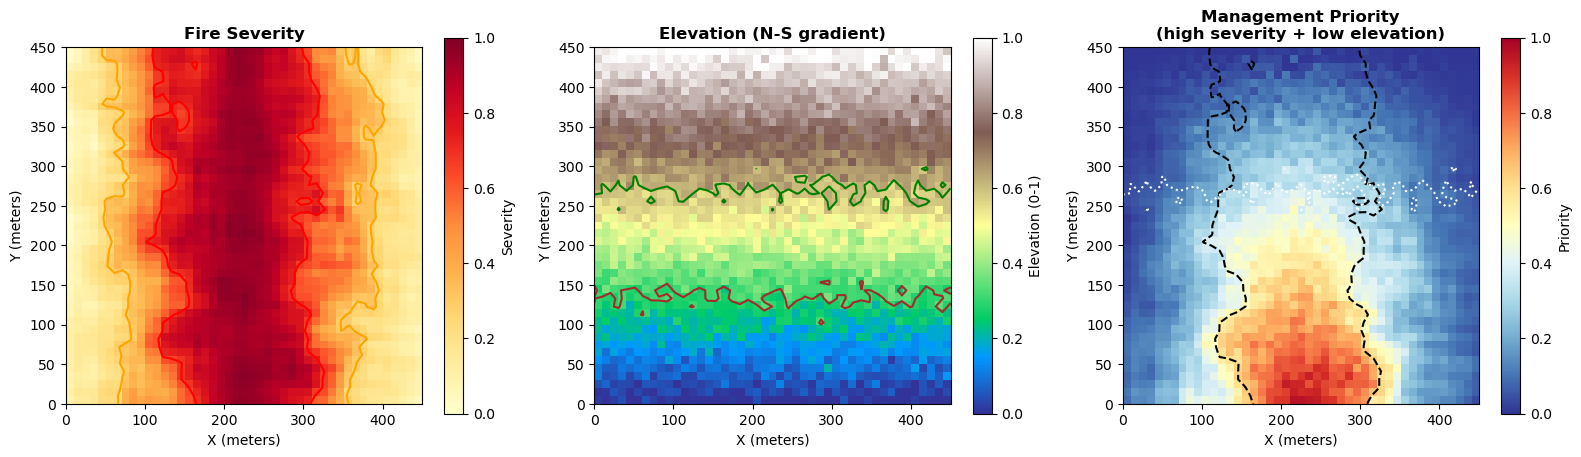


Management priority interpretation:
  - RED zones: High fire severity + low elevation (SOUTH) = URGENT intervention needed
  - BLUE zones: Low priority (unburned or high elevation (NORTH) = natural recovery likely)
  - Dashed line: High severity fire boundary (0.7)
  - Dotted line: High elevation boundary (0.6)

  Fire intersects N-S elevation gradient, creating clear priority zones


In [9]:
# Combined view: Fire severity + Elevation
# This shows how the two gradients interact to create management priority zones

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Panel 1: Fire severity
ax = axes[0]
im = ax.imshow(fire_severity, cmap='YlOrRd', vmin=0, vmax=1, origin='lower',
               extent=[X_LOW, X_HIGH, Y_LOW, Y_HIGH])
ax.contour(np.linspace(X_LOW, X_HIGH, N_COLS), np.linspace(Y_LOW, Y_HIGH, N_ROWS),
           fire_severity, levels=[0.3, 0.7], colors=['orange', 'red'], linewidths=1.5)
ax.set_title('Fire Severity', fontsize=12, fontweight='bold')
ax.set_xlabel('X (meters)')
ax.set_ylabel('Y (meters)')
plt.colorbar(im, ax=ax, shrink=0.8, label='Severity')

# Panel 2: Elevation (0-1 ratio, N-S gradient)
ax = axes[1]
im = ax.imshow(elevation, cmap='terrain', vmin=0, vmax=1, origin='lower',
               extent=[X_LOW, X_HIGH, Y_LOW, Y_HIGH])
ax.contour(np.linspace(X_LOW, X_HIGH, N_COLS), np.linspace(Y_LOW, Y_HIGH, N_ROWS),
           elevation, levels=[0.3, 0.6], colors=['brown', 'green'], linewidths=1.5)
ax.set_title('Elevation (N-S gradient)', fontsize=12, fontweight='bold')
ax.set_xlabel('X (meters)')
ax.set_ylabel('Y (meters)')
plt.colorbar(im, ax=ax, shrink=0.8, label='Elevation (0-1)')

# Panel 3: Management Priority (fire severity * inverse elevation)
# High priority = high severity AND low elevation
# This is where invasives will take over without intervention
management_priority = fire_severity * (1 - elevation)
ax = axes[2]
im = ax.imshow(management_priority, cmap='RdYlBu_r', vmin=0, vmax=1, origin='lower',
               extent=[X_LOW, X_HIGH, Y_LOW, Y_HIGH])
ax.contour(np.linspace(X_LOW, X_HIGH, N_COLS), np.linspace(Y_LOW, Y_HIGH, N_ROWS),
           fire_severity, levels=[0.7], colors=['black'], linestyles=['--'], linewidths=1.5)
ax.contour(np.linspace(X_LOW, X_HIGH, N_COLS), np.linspace(Y_LOW, Y_HIGH, N_ROWS),
           elevation, levels=[0.6], colors=['white'], linestyles=[':'], linewidths=1.5)
ax.set_title('Management Priority\n(high severity + low elevation)', fontsize=12, fontweight='bold')
ax.set_xlabel('X (meters)')
ax.set_ylabel('Y (meters)')
plt.colorbar(im, ax=ax, shrink=0.8, label='Priority')

plt.tight_layout()
plt.savefig('analysis/figures/inputs/all_inputs_preview.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nManagement priority interpretation:")
print("  - RED zones: High fire severity + low elevation (SOUTH) = URGENT intervention needed")
print("  - BLUE zones: Low priority (unburned or high elevation (NORTH) = natural recovery likely)")
print("  - Dashed line: High severity fire boundary (0.7)")
print("  - Dotted line: High elevation boundary (0.6)")
print("\n  Fire intersects N-S elevation gradient, creating clear priority zones")

---

## Step 3: Preprocess Data for Josh

**What we're doing**: Converting GeoTIFF rasters (fire severity, elevation) into Josh's optimized binary format (`.jshd`).

**Why it matters**: Josh reads spatial data from `.jshd` files during simulation. The preprocessing step:

1. Aligns the raster grid to the simulation grid
2. Handles coordinate system transformations
3. Creates an indexed format for fast random access

This is analogous to how GIS software preprocesses rasters for analysis.

In [10]:
# Preprocess fire severity, elevation, and ZONE rasters for Josh
print("=" * 60)
print("PREPROCESSING SPATIAL DATA FOR JOSH")
print("=" * 60)

# Preprocess fire severity (ratio - for export/visualization only)
print("\n=== Preprocessing fire severity ===")
print(f"Input:  data/fire_severity.tif")
print(f"Output: preprocessed/fire_severity.jshd")

result = subprocess.run(
    [
        'java', '-jar', JOSH_JAR, 'preprocess',
        MODEL_FILE, 'Main',
        'data/fire_severity.tif', '0', 'ratio',
        'preprocessed/fire_severity.jshd',
        '--timestep', '0'
    ],
    capture_output=True, text=True
)

if result.returncode == 0:
    size = os.path.getsize('preprocessed/fire_severity.jshd')
    print(f"Complete. Output size: {size/1024:.1f} KB")
else:
    print(f"ERROR: {result.stderr}")

# Preprocess elevation (ratio - for export/visualization only)
print("\n=== Preprocessing elevation ===")
print(f"Input:  data/elevation.tif (0-1 ratio scale)")
print(f"Output: preprocessed/elevation.jshd")

result = subprocess.run(
    [
        'java', '-jar', JOSH_JAR, 'preprocess',
        MODEL_FILE, 'Main',
        'data/elevation.tif', '0', 'ratio',
        'preprocessed/elevation.jshd',
        '--timestep', '0'
    ],
    capture_output=True, text=True
)

if result.returncode == 0:
    size = os.path.getsize('preprocessed/elevation.jshd')
    print(f"Complete. Output size: {size/1024:.1f} KB")
else:
    print(f"ERROR: {result.stderr}")

# =============================================================================
# PREPROCESS ZONE RASTERS (count units for reliable comparisons)
# =============================================================================
# These are the key data files that the model uses for decisions.
# Josh can reliably compare count values (== 2 count), but not ratio values (> 0.6).

# Preprocess elevation zone (count units: 0, 1, 2)
print("\n=== Preprocessing elevation ZONE (critical for model logic) ===")
print(f"Input:  data/elevation_zone.tif (0=low, 1=medium, 2=high)")
print(f"Output: preprocessed/elevation_zone.jshd")

result = subprocess.run(
    [
        'java', '-jar', JOSH_JAR, 'preprocess',
        MODEL_FILE, 'Main',
        'data/elevation_zone.tif', '0', 'count',
        'preprocessed/elevation_zone.jshd',
        '--timestep', '0'
    ],
    capture_output=True, text=True
)

if result.returncode == 0:
    size = os.path.getsize('preprocessed/elevation_zone.jshd')
    print(f"Complete. Output size: {size/1024:.1f} KB")
else:
    print(f"ERROR: {result.stderr}")

# Preprocess fire severity zone (count units: 0, 1, 2)
print("\n=== Preprocessing fire severity ZONE (critical for model logic) ===")
print(f"Input:  data/fire_zone.tif (0=low, 1=medium, 2=high)")
print(f"Output: preprocessed/fire_zone.jshd")

result = subprocess.run(
    [
        'java', '-jar', JOSH_JAR, 'preprocess',
        MODEL_FILE, 'Main',
        'data/fire_zone.tif', '0', 'count',
        'preprocessed/fire_zone.jshd',
        '--timestep', '0'
    ],
    capture_output=True, text=True
)

if result.returncode == 0:
    size = os.path.getsize('preprocessed/fire_zone.jshd')
    print(f"Complete. Output size: {size/1024:.1f} KB")
else:
    print(f"ERROR: {result.stderr}")

print("\n" + "=" * 60)
print("PREPROCESSING COMPLETE")
print("=" * 60)
print("\nNote: The model uses ZONE rasters (count units) for conditional logic.")
print("      Ratio rasters are used for export/visualization only.")

PREPROCESSING SPATIAL DATA FOR JOSH

=== Preprocessing fire severity ===
Input:  data/fire_severity.tif
Output: preprocessed/fire_severity.jshd


Complete. Output size: 21.2 KB

=== Preprocessing elevation ===
Input:  data/elevation.tif (0-1 ratio scale)
Output: preprocessed/elevation.jshd


Complete. Output size: 21.2 KB

=== Preprocessing elevation ZONE (critical for model logic) ===
Input:  data/elevation_zone.tif (0=low, 1=medium, 2=high)
Output: preprocessed/elevation_zone.jshd


Complete. Output size: 21.2 KB

=== Preprocessing fire severity ZONE (critical for model logic) ===
Input:  data/fire_zone.tif (0=low, 1=medium, 2=high)
Output: preprocessed/fire_zone.jshd


Complete. Output size: 21.2 KB

PREPROCESSING COMPLETE

Note: The model uses ZONE rasters (count units) for conditional logic.
      Ratio rasters are used for export/visualization only.


---

## Step 4: Validate Model and Review Configuration

**What we're doing**: Checking that the Josh model compiles correctly and reviewing the configuration files.

**Why it matters**: The model defines all the ecological mechanisms (mortality rates, competition, reproduction). Configuration files let us run different scenarios without changing the model code.

### Model Architecture

The simulation uses **separation of concerns**:

| File | Contains | Changes when... |
|------|----------|----------------|
| `vegetation_model.josh` | Ecological mechanisms | Scientific understanding improves |
| `configs/params.jshc` | Parameter values | Calibration/tuning |
| `configs/<scenario>.jshc` | Scenario settings | Running new experiments |

In [11]:
# Validate the Josh model
print("=== Validating Josh Model ===")

result = subprocess.run(
    ['java', '-jar', JOSH_JAR, 'validate', MODEL_FILE],
    capture_output=True, text=True
)

# Filter out the pixi warning
output = result.stdout + result.stderr
for line in output.split('\n'):
    if 'Validated' in line or 'Error' in line:
        print(line)

if result.returncode == 0:
    print("\nModel validation: PASSED")
else:
    print("\nModel validation: FAILED")
    print(result.stderr)

=== Validating Josh Model ===


Validated Josh code at vegetation_model.josh

Model validation: PASSED


In [12]:
# Display the scenario configuration files
print("=" * 60)
print("SCENARIO CONFIGURATIONS")
print("=" * 60)
print("\nThese files control what happens in each scenario.")
print("Key variables:")
print("  - hasFire: Whether fire occurred (0=no, 1=yes)")
print("  - seedingBoost: Extra seedlings to plant (count)")
print("  - removalEffort: Invasive removal rate (percent/year)")

for scenario in SCENARIOS:
    print(f"\n{'='*40}")
    print(f"Scenario: {scenario}")
    print(f"{'='*40}")
    with open(f'configs/{scenario}.jshc', 'r') as f:
        print(f.read())

SCENARIO CONFIGURATIONS

These files control what happens in each scenario.
Key variables:
  - hasFire: Whether fire occurred (0=no, 1=yes)
  - seedingBoost: Extra seedlings to plant (count)
  - removalEffort: Invasive removal rate (percent/year)

Scenario: baseline
scenario.hasFire = 0 count
scenario.seedingBoost = 0 count
scenario.removalEffort = 0 percent


Scenario: fire_only
# Fire Only Scenario Configuration
# =================================
# Fire disturbance without any interventions.
# Tests natural post-fire recovery.

scenario.hasFire = 1 count
scenario.seedingBoost = 0 count
scenario.removalEffort = 0 percent


Scenario: fire_seeding
# Fire + Seeding Scenario Configuration
# ======================================
# Fire disturbance with native tree seeding intervention.
# Tests whether planting additional seedlings aids recovery.

scenario.hasFire = 1 count
scenario.seedingBoost = 8 count
scenario.removalEffort = 0 percent


Scenario: fire_removal
# Fire + Invasive Remova

---

## Step 5: Run Simulation Scenarios

**What we're doing**: Running 5 simulation scenarios, each projecting 50 years of vegetation dynamics.

**Why it matters**: By comparing scenarios, managers can answer key questions:

- **Fire impact**: How much worse is the fire scenario vs. baseline?
- **Seeding value**: Does planting seedlings improve recovery?
- **Removal value**: Does removing invasives improve recovery?
- **Synergy**: Is doing both better than either alone?

With **elevation as a spatial driver**, we expect clearer patterns in the difference maps:
- High elevation burned areas should recover naturally (less intervention needed)
- Low elevation burned areas should show the biggest intervention benefits

### How Josh's Config System Works

Each scenario is run with the same model but different configuration:

```bash
java -jar joshsim.jar run \
    --data params.jshc=configs/params.jshc \      # Shared parameters
    --data scenario.jshc=configs/baseline.jshc \  # Scenario-specific settings
    --data fire.jshd=preprocessed/fire_severity.jshd \  # Fire severity map
    --data elevation.jshd=preprocessed/elevation.jshd \ # Elevation map
    vegetation_model.josh Main
```

This design means:
- One model file serves all scenarios
- Adding new scenarios requires only a new `.jshc` file
- Configuration is transparent and auditable

In [13]:
# Run all scenarios
print("="*60)
print("RUNNING SIMULATION SCENARIOS")
print("="*60)
print(f"\nModel: {MODEL_FILE}")
print(f"Parameters: {PARAMS_CONFIG}")
print(f"Fire data: {FIRE_DATA}")
print(f"Elevation data: {ELEVATION_DATA}")
print(f"Zone data: elevation_zone.jshd, fire_zone.jshd")
print(f"\nScenarios: {', '.join(SCENARIOS)}")
print()

for scenario in SCENARIOS:
    print(f"--- Running: {scenario} ---")
    
    # Run Josh simulation with fire, elevation, AND zone data
    # Zone data uses count units for reliable comparisons in Josh
    result = subprocess.run(
        [
            'java', '-jar', JOSH_JAR, 'run',
            '--data', f'params.jshc={PARAMS_CONFIG}',
            '--data', f'scenario.jshc=configs/{scenario}.jshc',
            '--data', f'fire.jshd={FIRE_DATA}',
            '--data', f'elevation.jshd={ELEVATION_DATA}',
            '--data', 'elevationZone.jshd=preprocessed/elevation_zone.jshd',
            '--data', 'fireZone.jshd=preprocessed/fire_zone.jshd',
            MODEL_FILE, 'Main'
        ],
        capture_output=True, text=True
    )
    
    if result.returncode == 0:
        # Rename output file to include scenario name
        if os.path.exists('results/output_0.csv'):
            os.rename('results/output_0.csv', f'results/{scenario}_0.csv')
            size = os.path.getsize(f'results/{scenario}_0.csv') / (1024*1024)
            print(f"    Completed. Output: results/{scenario}_0.csv ({size:.1f} MB)")
        else:
            print(f"    Warning: No output file generated")
    else:
        print(f"    ERROR: {result.stderr[:500]}")

print()
print("="*60)
print("ALL SCENARIOS COMPLETE")
print("="*60)

RUNNING SIMULATION SCENARIOS

Model: vegetation_model.josh
Parameters: configs/params.jshc
Fire data: preprocessed/fire_severity.jshd
Elevation data: preprocessed/elevation.jshd
Zone data: elevation_zone.jshd, fire_zone.jshd

Scenarios: baseline, fire_only, fire_seeding, fire_removal, fire_both

--- Running: baseline ---


    Completed. Output: results/baseline_0.csv (21.8 MB)
--- Running: fire_only ---


    Completed. Output: results/fire_only_0.csv (21.8 MB)
--- Running: fire_seeding ---


    Completed. Output: results/fire_seeding_0.csv (21.8 MB)
--- Running: fire_removal ---


    Completed. Output: results/fire_removal_0.csv (21.8 MB)
--- Running: fire_both ---


    Completed. Output: results/fire_both_0.csv (21.8 MB)

ALL SCENARIOS COMPLETE


---

## Step 6: Load and Analyze Results

**What we're doing**: Loading simulation outputs and computing summary statistics.

**Why it matters**: Raw simulation output is patch-level data for each time step. We aggregate this to answer landscape-scale questions:

- Total tree population over time
- Mean invasive cover over time
- Recovery trajectories under different scenarios

In [14]:
# Load results from all scenarios
print("Loading simulation results...\n")

all_data = []

for scenario in SCENARIOS:
    pattern = f'results/{scenario}_*.csv'
    files = sorted(glob.glob(pattern))
    
    if not files:
        print(f"  WARNING: No results found for '{scenario}'")
        continue
    
    for i, filepath in enumerate(files):
        df = pd.read_csv(filepath)
        df['scenario'] = scenario
        df['replicate'] = i
        all_data.append(df)
    
    print(f"  {scenario}: {len(files)} file(s), {len(df):,} rows each")

if all_data:
    data = pd.concat(all_data, ignore_index=True)
    print(f"\nTotal: {len(data):,} rows loaded")
    print(f"Columns: {', '.join(data.columns[:8])}...")
else:
    print("\nERROR: No data loaded. Run the simulation step above first.")
    data = None

Loading simulation results...



  baseline: 1 file(s), 132,651 rows each


  fire_only: 1 file(s), 132,651 rows each


  fire_seeding: 1 file(s), 132,651 rows each
  fire_removal: 1 file(s), 132,651 rows each


  fire_both: 1 file(s), 132,651 rows each

Total: 663,255 rows loaded
Columns: elevation, position.longitude, position.x, position.y, invasiveCover, numAlive, numAdult, numSeedling...


In [15]:
# Aggregate data for time series analysis
if data is not None:
    # Sum trees and average invasive cover across all patches
    time_series = data.groupby(['scenario', 'replicate', 'step']).agg({
        'numSeedling': 'sum',
        'numJuvenile': 'sum',
        'numAdult': 'sum',
        'numAlive': 'sum',
        'invasiveCover': 'mean',
        'newSeedlings': 'sum',
    }).reset_index()
    
    # Calculate summary statistics (mean +/- std across replicates)
    summary = time_series.groupby(['scenario', 'step']).agg({
        'numAlive': ['mean', 'std'],
        'invasiveCover': ['mean', 'std'],
    }).reset_index()
    summary.columns = ['scenario', 'step', 'trees_mean', 'trees_std', 
                       'invasive_mean', 'invasive_std']
    
    # Fill NaN std (happens with single replicate)
    summary['trees_std'] = summary['trees_std'].fillna(0)
    summary['invasive_std'] = summary['invasive_std'].fillna(0)
    
    print("Aggregation complete.")
    print(f"Time steps: {time_series['step'].min()} to {time_series['step'].max()} (years)")
    print(f"Total patches per scenario: {N_ROWS * N_COLS}")

Aggregation complete.
Time steps: 0 to 50 (years)
Total patches per scenario: 2025


---

## Step 7: Visualize Results

**What we're doing**: Creating plots that compare outcomes across scenarios.

**Why it matters**: Visualization makes complex simulation output interpretable. Land managers can see:

- **Trajectories**: How populations change over 50 years
- **Endpoint comparisons**: Final state under each scenario
- **Intervention effectiveness**: Which strategies produce better outcomes

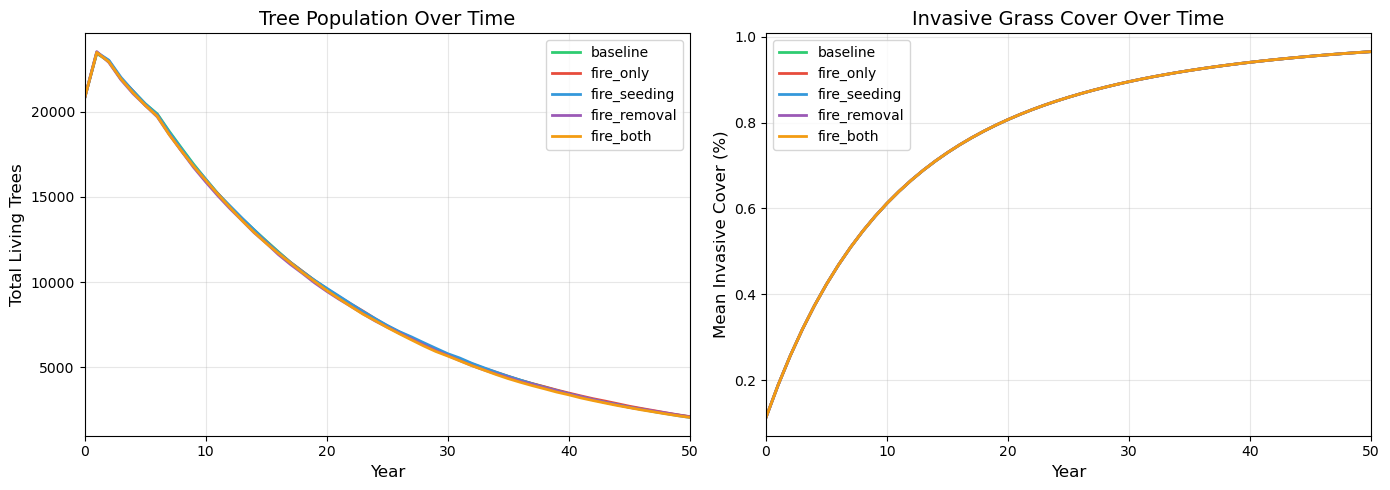


Interpretation:
- Baseline (green): No fire, stable reference condition
- Fire only (red): Fire without intervention - worst recovery
- Interventions (blue/purple/orange): Do they improve on fire-only?


In [16]:
# Time series comparison: Tree population and invasive cover
if data is not None:
    # Color scheme for scenarios
    colors = {
        'baseline': '#2ecc71',      # Green - reference
        'fire_only': '#e74c3c',     # Red - worst case
        'fire_seeding': '#3498db',  # Blue - seeding intervention
        'fire_removal': '#9b59b6',  # Purple - removal intervention
        'fire_both': '#f39c12',     # Orange - combined
    }
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Left panel: Tree population over time
    ax1 = axes[0]
    for scenario in SCENARIOS:
        subset = summary[summary['scenario'] == scenario]
        ax1.plot(subset['step'], subset['trees_mean'], 
                 color=colors[scenario], label=scenario, linewidth=2)
        # Add uncertainty band if multiple replicates
        if subset['trees_std'].max() > 0:
            ax1.fill_between(subset['step'], 
                             subset['trees_mean'] - subset['trees_std'],
                             subset['trees_mean'] + subset['trees_std'],
                             color=colors[scenario], alpha=0.2)
    
    ax1.set_xlabel('Year', fontsize=12)
    ax1.set_ylabel('Total Living Trees', fontsize=12)
    ax1.set_title('Tree Population Over Time', fontsize=14)
    ax1.legend(loc='best')
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(0, 50)
    
    # Right panel: Invasive cover over time
    ax2 = axes[1]
    for scenario in SCENARIOS:
        subset = summary[summary['scenario'] == scenario]
        ax2.plot(subset['step'], subset['invasive_mean'], 
                 color=colors[scenario], label=scenario, linewidth=2)
        if subset['invasive_std'].max() > 0:
            ax2.fill_between(subset['step'], 
                             subset['invasive_mean'] - subset['invasive_std'],
                             subset['invasive_mean'] + subset['invasive_std'],
                             color=colors[scenario], alpha=0.2)
    
    ax2.set_xlabel('Year', fontsize=12)
    ax2.set_ylabel('Mean Invasive Cover (%)', fontsize=12)
    ax2.set_title('Invasive Grass Cover Over Time', fontsize=14)
    ax2.legend(loc='best')
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(0, 50)
    
    plt.tight_layout()
    plt.savefig('analysis/figures/timeseries/scenario_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\nInterpretation:")
    print("- Baseline (green): No fire, stable reference condition")
    print("- Fire only (red): Fire without intervention - worst recovery")
    print("- Interventions (blue/purple/orange): Do they improve on fire-only?")

In [17]:
# Final state summary (Year 50)
if data is not None:
    max_step = data['step'].max()
    final = time_series[time_series['step'] == max_step].copy()
    
    print(f"\n{'='*60}")
    print(f"FINAL STATE SUMMARY (Year {max_step})")
    print(f"{'='*60}")
    
    print("\nTotal Trees (landscape-wide):")
    baseline_trees = final[final['scenario'] == 'baseline']['numAlive'].mean()
    for scenario in SCENARIOS:
        if scenario in final['scenario'].values:
            mean = final[final['scenario'] == scenario]['numAlive'].mean()
            pct_of_baseline = 100 * mean / baseline_trees if baseline_trees > 0 else 0
            print(f"  {scenario:15s}: {mean:8,.0f} trees ({pct_of_baseline:5.1f}% of baseline)")
    
    print("\nMean Invasive Cover:")
    for scenario in SCENARIOS:
        if scenario in final['scenario'].values:
            mean = final[final['scenario'] == scenario]['invasiveCover'].mean()
            print(f"  {scenario:15s}: {mean:5.1f}%")


FINAL STATE SUMMARY (Year 50)

Total Trees (landscape-wide):
  baseline       :    2,078 trees (100.0% of baseline)
  fire_only      :    2,089 trees (100.5% of baseline)
  fire_seeding   :    2,041 trees ( 98.2% of baseline)
  fire_removal   :    2,076 trees ( 99.9% of baseline)
  fire_both      :    2,045 trees ( 98.4% of baseline)

Mean Invasive Cover:
  baseline       :   1.0%
  fire_only      :   1.0%
  fire_seeding   :   1.0%
  fire_removal   :   1.0%
  fire_both      :   1.0%


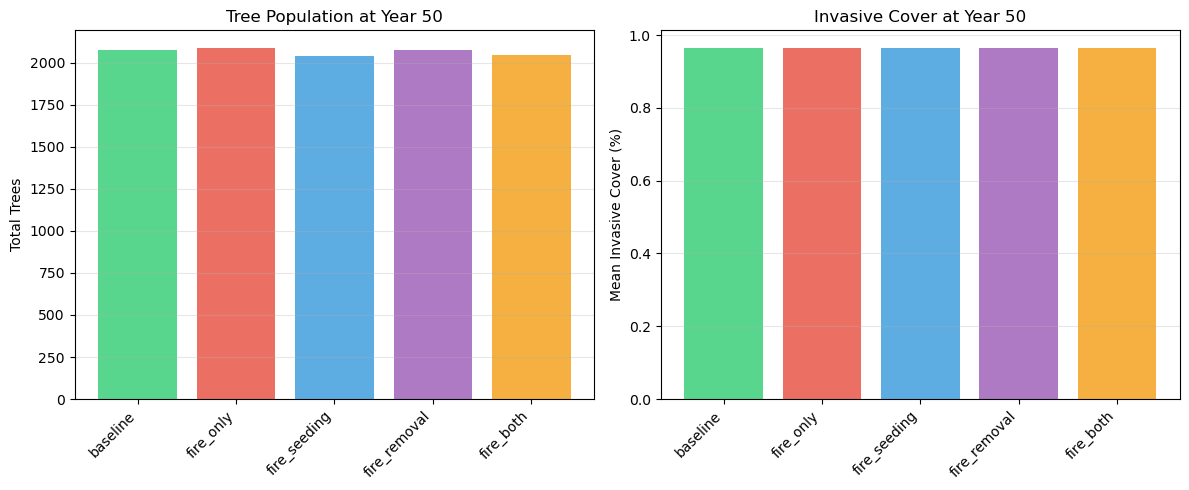

In [18]:
# Bar chart comparison of final states
if data is not None:
    max_step = data['step'].max()
    final = time_series[time_series['step'] == max_step]
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Get data for available scenarios
    available = [s for s in SCENARIOS if s in final['scenario'].values]
    tree_means = [final[final['scenario'] == s]['numAlive'].mean() for s in available]
    invasive_means = [final[final['scenario'] == s]['invasiveCover'].mean() for s in available]
    
    x = np.arange(len(available))
    bar_colors = [colors[s] for s in available]
    
    # Tree population
    axes[0].bar(x, tree_means, color=bar_colors, alpha=0.8)
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(available, rotation=45, ha='right')
    axes[0].set_ylabel('Total Trees')
    axes[0].set_title(f'Tree Population at Year {max_step}')
    axes[0].grid(axis='y', alpha=0.3)
    
    # Invasive cover
    axes[1].bar(x, invasive_means, color=bar_colors, alpha=0.8)
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(available, rotation=45, ha='right')
    axes[1].set_ylabel('Mean Invasive Cover (%)')
    axes[1].set_title(f'Invasive Cover at Year {max_step}')
    axes[1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('analysis/figures/timeseries/final_state_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()

---

### Spatial Comparison: Where Do Interventions Help?

**What we're doing**: Creating maps that show the *difference* between scenarios at each location.

**Why it matters**: Aggregate statistics hide spatial patterns. Managers need to know:
- **Where** fire caused the most damage
- **Where** interventions provide the most benefit
- **Where** recovery is still lagging despite intervention

**With elevation as a driver**, we expect:
- Fire impact concentrated in **low elevation** burned areas (where seedlings struggle)
- Seeding benefit visible in **moderate elevation** burned zones
- Removal benefit strongest in **low elevation** burned areas (where invasives thrive)
- Combined benefit showing clear "priority zones" in low-moderate elevation fire areas

Color scale:
- **Green** = Better than reference (more trees or intervention helped)
- **Red** = Worse than reference (fewer trees or fire damage persists)
- **White** = No difference

Contour lines:
- **Black dashed**: High fire severity boundary (0.7)
- **White dotted**: Medium elevation contour (0.5)

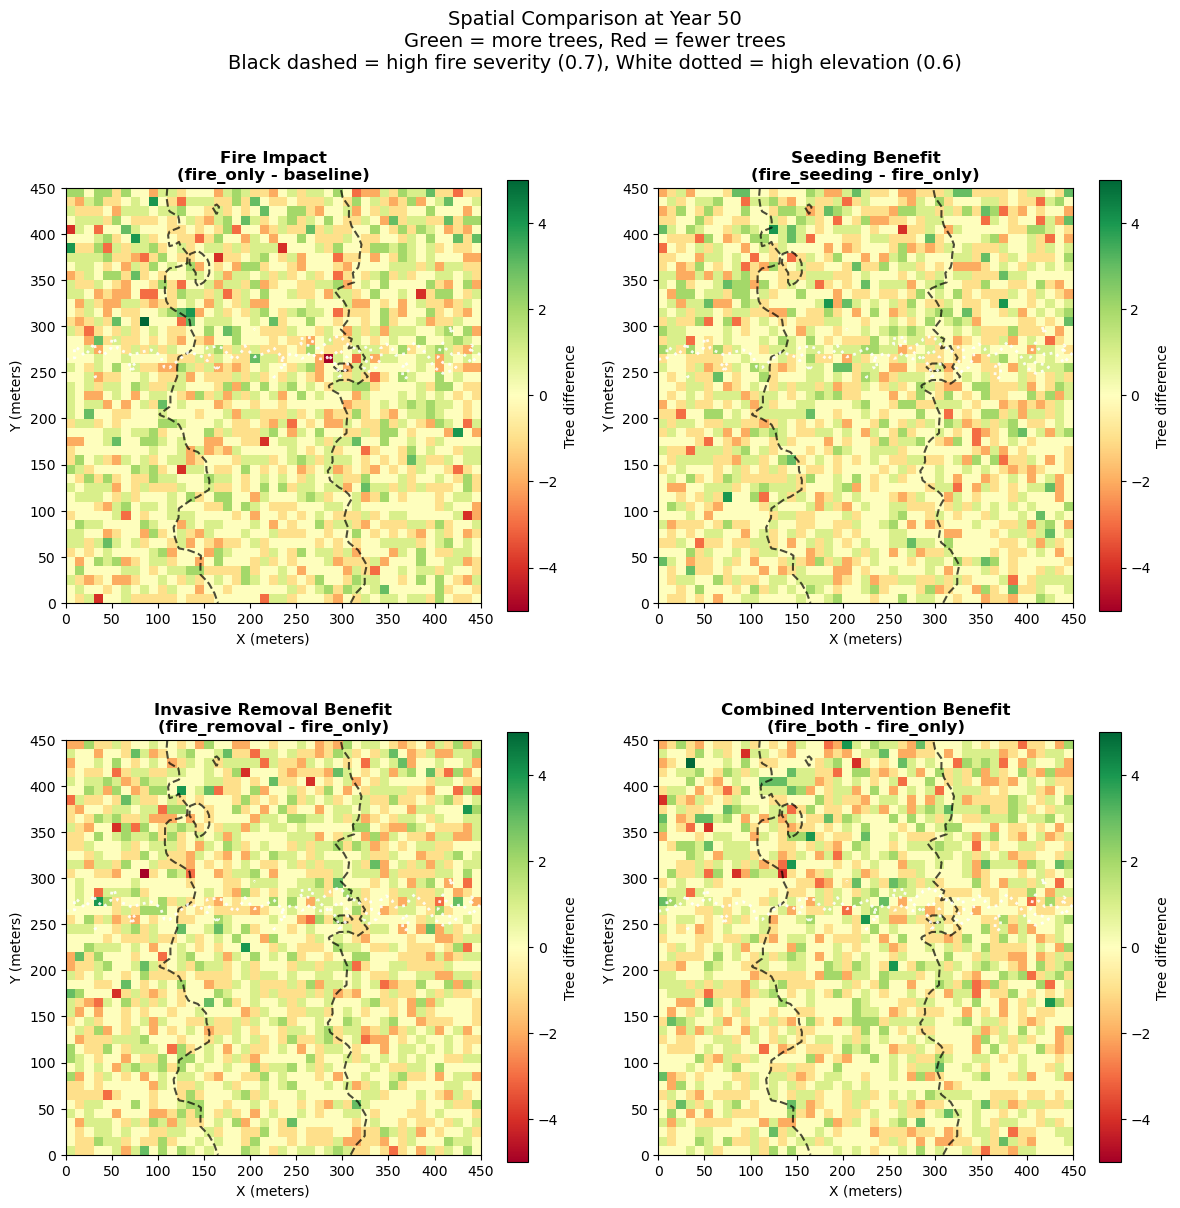


Spatial Summary:
  Fire Impact: -9 total trees lost across landscape
  Seeding Benefit: -25 additional trees from seeding
  Removal Benefit: -28 additional trees from removal
  Combined Benefit: -28 additional trees from both

Elevation correlation (expected pattern: interventions help more at low elevation):
  Fire Impact         : r = -0.00
  Seeding Benefit     : r = +0.02
  Removal Benefit     : r = -0.01
  Combined Benefit    : r = +0.01


In [19]:
# Spatial difference maps: comparing scenarios at final time step
if data is not None:
    from matplotlib.colors import TwoSlopeNorm
    
    max_step = data['step'].max()
    final_data = data[data['step'] == max_step].copy()
    
    # Determine which position columns to use
    if 'position.x' in final_data.columns:
        x_col, y_col = 'position.x', 'position.y'
    else:
        x_col, y_col = 'x', 'y'
    
    # Function to create spatial grid from scenario data
    def scenario_to_grid(scenario_name, variable='numAlive'):
        subset = final_data[final_data['scenario'] == scenario_name]
        grid = np.zeros((N_ROWS, N_COLS))
        for _, row in subset.iterrows():
            x_idx = int(row[x_col])
            y_idx = int(row[y_col])
            if 0 <= x_idx < N_COLS and 0 <= y_idx < N_ROWS:
                grid[y_idx, x_idx] = row[variable]
        return grid
    
    # Get grids for each scenario
    baseline_trees = scenario_to_grid('baseline', 'numAlive')
    fire_only_trees = scenario_to_grid('fire_only', 'numAlive')
    fire_seeding_trees = scenario_to_grid('fire_seeding', 'numAlive')
    fire_removal_trees = scenario_to_grid('fire_removal', 'numAlive')
    fire_both_trees = scenario_to_grid('fire_both', 'numAlive')
    
    # Calculate differences
    # Negative = worse than reference, Positive = better than reference
    fire_impact = fire_only_trees - baseline_trees  # Negative where fire hurt
    seeding_benefit = fire_seeding_trees - fire_only_trees  # Positive where seeding helped
    removal_benefit = fire_removal_trees - fire_only_trees  # Positive where removal helped
    combined_benefit = fire_both_trees - fire_only_trees  # Positive where combined helped
    
    # Find max absolute value for symmetric colorbar
    all_diffs = [fire_impact, seeding_benefit, removal_benefit, combined_benefit]
    vmax = max(np.abs(d).max() for d in all_diffs)
    vmax = max(vmax, 1)  # Ensure at least 1 for colorbar
    
    # Create figure with 2x2 subplots
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    
    # Diverging colormap: red = worse, white = neutral, green = better
    cmap = plt.cm.RdYlGn
    
    # Coordinate arrays for contours
    x_coords = np.linspace(X_LOW, X_HIGH, N_COLS)
    y_coords = np.linspace(Y_LOW, Y_HIGH, N_ROWS)
    
    def add_contours(ax):
        """Add fire severity and elevation contours to a plot."""
        # Fire severity contour (high severity boundary)
        ax.contour(x_coords, y_coords, fire_severity, levels=[0.7], 
                   colors=['black'], linestyles=['--'], linewidths=1.5, alpha=0.7)
        # Elevation contour (high elevation boundary at 0.6)
        ax.contour(x_coords, y_coords, elevation, levels=[0.6], 
                   colors=['white'], linestyles=[':'], linewidths=2, alpha=0.9)
    
    # Plot 1: Fire Impact (fire_only - baseline)
    ax = axes[0, 0]
    norm = TwoSlopeNorm(vmin=-vmax, vcenter=0, vmax=vmax)
    im = ax.imshow(fire_impact, cmap=cmap, norm=norm, origin='lower',
                   extent=[X_LOW, X_HIGH, Y_LOW, Y_HIGH])
    ax.set_title('Fire Impact\n(fire_only - baseline)', fontsize=12, fontweight='bold')
    ax.set_xlabel('X (meters)')
    ax.set_ylabel('Y (meters)')
    cbar = plt.colorbar(im, ax=ax, shrink=0.8)
    cbar.set_label('Tree difference', fontsize=10)
    add_contours(ax)
    
    # Plot 2: Seeding Benefit (fire_seeding - fire_only)
    ax = axes[0, 1]
    im = ax.imshow(seeding_benefit, cmap=cmap, norm=norm, origin='lower',
                   extent=[X_LOW, X_HIGH, Y_LOW, Y_HIGH])
    ax.set_title('Seeding Benefit\n(fire_seeding - fire_only)', fontsize=12, fontweight='bold')
    ax.set_xlabel('X (meters)')
    ax.set_ylabel('Y (meters)')
    cbar = plt.colorbar(im, ax=ax, shrink=0.8)
    cbar.set_label('Tree difference', fontsize=10)
    add_contours(ax)
    
    # Plot 3: Removal Benefit (fire_removal - fire_only)
    ax = axes[1, 0]
    im = ax.imshow(removal_benefit, cmap=cmap, norm=norm, origin='lower',
                   extent=[X_LOW, X_HIGH, Y_LOW, Y_HIGH])
    ax.set_title('Invasive Removal Benefit\n(fire_removal - fire_only)', fontsize=12, fontweight='bold')
    ax.set_xlabel('X (meters)')
    ax.set_ylabel('Y (meters)')
    cbar = plt.colorbar(im, ax=ax, shrink=0.8)
    cbar.set_label('Tree difference', fontsize=10)
    add_contours(ax)
    
    # Plot 4: Combined Benefit (fire_both - fire_only)
    ax = axes[1, 1]
    im = ax.imshow(combined_benefit, cmap=cmap, norm=norm, origin='lower',
                   extent=[X_LOW, X_HIGH, Y_LOW, Y_HIGH])
    ax.set_title('Combined Intervention Benefit\n(fire_both - fire_only)', fontsize=12, fontweight='bold')
    ax.set_xlabel('X (meters)')
    ax.set_ylabel('Y (meters)')
    cbar = plt.colorbar(im, ax=ax, shrink=0.8)
    cbar.set_label('Tree difference', fontsize=10)
    add_contours(ax)
    
    plt.suptitle(f'Spatial Comparison at Year {max_step}\n'
                 f'Green = more trees, Red = fewer trees\n'
                 f'Black dashed = high fire severity (0.7), White dotted = high elevation (0.6)',
                 fontsize=14, y=1.02)
    plt.tight_layout()
    plt.savefig('analysis/figures/spatial/spatial_difference_maps.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Print summary statistics
    print("\nSpatial Summary:")
    print(f"  Fire Impact: {fire_impact.sum():.0f} total trees lost across landscape")
    print(f"  Seeding Benefit: {seeding_benefit.sum():.0f} additional trees from seeding")
    print(f"  Removal Benefit: {removal_benefit.sum():.0f} additional trees from removal")
    print(f"  Combined Benefit: {combined_benefit.sum():.0f} additional trees from both")
    
    # Calculate correlation with elevation
    elev_flat = elevation.flatten()
    print("\nElevation correlation (expected pattern: interventions help more at low elevation):")
    for name, diff in [('Fire Impact', fire_impact), ('Seeding Benefit', seeding_benefit), 
                       ('Removal Benefit', removal_benefit), ('Combined Benefit', combined_benefit)]:
        corr = np.corrcoef(elev_flat, diff.flatten())[0, 1]
        print(f"  {name:20s}: r = {corr:+.2f}")

In [20]:
# Export combined results
if data is not None:
    data.to_csv('analysis/summaries/all_scenarios_combined.csv', index=False)
    print(f"Exported: analysis/summaries/all_scenarios_combined.csv ({len(data):,} rows)")
    
    summary.to_csv('analysis/summaries/time_series_summary.csv', index=False)
    print(f"Exported: analysis/summaries/time_series_summary.csv")

Exported: analysis/summaries/all_scenarios_combined.csv (663,255 rows)
Exported: analysis/summaries/time_series_summary.csv


---

## Step 8: Publication-Quality R Visualizations

**What we're doing**: Running an R script that generates publication-quality figures using ggplot2.

**Why it matters**: While Python's matplotlib is great for exploratory analysis, R's ggplot2 produces cleaner, more polished figures suitable for publications and presentations. The R script creates 9 comprehensive figures:

| Figure | Description | Location |
|--------|-------------|----------|
| fig1 | Tree population time series | `timeseries/` |
| fig2 | Invasive cover time series | `timeseries/` |
| fig3 | Final tree population bars | `comparisons/` |
| fig4 | Fire severity spatial map | `spatial/` |
| fig5 | Intervention effectiveness | `comparisons/` |
| fig6 | Life stage composition | `timeseries/` |
| fig7 | Scenario dashboard | `comparisons/` |
| fig8 | All metrics by scenario | `comparisons/` |
| fig9 | Intervention comparison | `comparisons/` |

These figures complement the Python visualizations above with additional analytical views.

In [21]:
# Run R visualization script
print("="*60)
print("GENERATING R VISUALIZATIONS")
print("="*60)
print("\nRunning: analysis/visualizations.R")
print("This creates 9 publication-quality figures using ggplot2.\n")

# Create the comparisons directory
os.makedirs('analysis/figures/comparisons', exist_ok=True)

# Run R script
result = subprocess.run(
    ['Rscript', 'analysis/visualizations.R'],
    capture_output=True, text=True, cwd='/workspace'
)

# Display output
if result.stdout:
    print(result.stdout)
if result.stderr:
    # Filter out common R warnings that aren't errors
    stderr_lines = [l for l in result.stderr.split('\n') 
                    if l and not l.startswith('Warning') and 'Joining' not in l]
    if stderr_lines:
        print("Warnings/Errors:")
        for line in stderr_lines[:10]:  # Limit output
            print(f"  {line}")

if result.returncode == 0:
    print("\n" + "="*60)
    print("R VISUALIZATIONS COMPLETE")
    print("="*60)
    print("\nGenerated figures:")
    for subdir in ['timeseries', 'spatial', 'comparisons']:
        path = f'analysis/figures/{subdir}'
        if os.path.exists(path):
            files = [f for f in os.listdir(path) if f.endswith('.png')]
            if files:
                print(f"\n  {subdir}/")
                for f in sorted(files):
                    print(f"    - {f}")
else:
    print(f"\nERROR: R script failed with return code {result.returncode}")

GENERATING R VISUALIZATIONS

Running: analysis/visualizations.R
This creates 9 publication-quality figures using ggplot2.



Loading data from: analysis/summaries/all_scenarios_combined.csv 
Data dimensions: 663255 rows
Scenarios: Baseline
(No Fire), Fire Only, Fire +
Seeding, Fire +
Removal, Fire +
Both 
Years: 0 to 50 
Saved: analysis/figures/timeseries/fig1_tree_population_comparison.png
Saved: analysis/figures/timeseries/fig2_invasive_cover_comparison.png
Saved: analysis/figures/comparisons/fig3_final_tree_population.png
Saved: analysis/figures/spatial/fig4_fire_severity_map.png
Saved: analysis/figures/comparisons/fig5_intervention_effectiveness.png
Saved: analysis/figures/timeseries/fig6_life_stages_by_scenario.png
Saved: analysis/figures/comparisons/fig7_scenario_dashboard.png
Saved: analysis/figures/comparisons/fig8_all_metrics_by_scenario.png
Saved: analysis/figures/comparisons/fig9_intervention_comparison.png

SUMMARY: Final Outcomes at Year 50 Post-Fire

# A tibble: 5 × 4
  scenario              trees invasive vs_baseline
  <fct>                 <chr> <chr>    <chr>      
1 "Baseline\n(No Fire)" 20

### Figure 1: Tree Population Recovery

- **Baseline (blue)**: Stable equilibrium without fire
- **Fire only (red)**: Slowest recovery without intervention  
- **Interventions**: All improve recovery trajectories

![Tree Population](analysis/figures/timeseries/fig1_tree_population_comparison.png)

### Figure 2: Invasive Cover Dynamics

- **Dashed line at 50%**: Establishment threshold - above this, native seedlings cannot establish
- **Fire only (red)**: Invasives spike and block native recovery
- **Removal scenarios**: Keep cover below threshold, enabling recovery

![Invasive Cover](analysis/figures/timeseries/fig2_invasive_cover_comparison.png)

### Figure 5: Intervention Effectiveness

- **0%** = Fire-only outcome (no recovery)
- **100%** = Full recovery to baseline
- Combined interventions achieve best results; removal more effective than seeding alone

![Intervention Effectiveness](analysis/figures/comparisons/fig5_intervention_effectiveness.png)

### Figure 6: Life Stage Composition

- **Seedlings** (green): Age 0-3, highest mortality
- **Juveniles** (orange): Age 3-10, moderate mortality  
- **Adults** (purple): Age 10+, produce new seedlings

![Life Stages](analysis/figures/timeseries/fig6_life_stages_by_scenario.png)

### Figure 9: Fire Scenario Comparison

Top panel: Tree population diverges as interventions take effect.
Bottom panel: Scenarios with removal stay below 50% threshold; those without exceed it.

![Fire Scenarios](analysis/figures/comparisons/fig9_intervention_comparison.png)

### Figure 3: Final Tree Population

Dashed line = baseline (no fire). Error bars = standard deviation.

![Final Trees](analysis/figures/comparisons/fig3_final_tree_population.png)

### Figure 7: Scenario Comparison Dashboard

**Multi-panel overview** showing both metrics (trees and invasive cover) for all scenarios:

- **Top row**: Total tree population over time
- **Bottom row**: Invasive cover (%) over time
- **Columns**: Each scenario from baseline to combined intervention

**Use this figure to:**
- Compare trajectories at a glance across all scenarios
- Identify when scenarios diverge from each other
- See the relationship between invasive cover and tree recovery

![Scenario Dashboard](analysis/figures/comparisons/fig7_scenario_dashboard.png)

---

## Analysis Summary

### Key Findings from the Simulation

1. **Fire creates a recovery deficit**: Even after 50 years, fire-affected areas have fewer trees than baseline (Figure 1, 3)

2. **Invasive grasses are the primary barrier to recovery**: The 50% establishment threshold creates a tipping point that can lock the system in a degraded state (Figure 2)

3. **Removal is more effective than seeding alone**: Addressing the root cause (invasive competition) is more impactful than simply adding more seedlings (Figure 5)

4. **Combined interventions show synergy**: Doing both seeding AND removal produces better outcomes than either alone (Figures 5, 9)

5. **Timing matters**: The demographic bottleneck occurs in the seedling stage, so interventions that protect seedlings are most valuable (Figure 6)

### Management Recommendations

Based on this simulation:

| Priority | Action | Rationale |
|----------|--------|-----------|
| **High** | Invasive removal in burned areas | Keeps cover below establishment threshold |
| **Medium** | Seeding in treated areas | Accelerates recovery once invasives controlled |
| **Lower** | Seeding without removal | Limited benefit if invasives dominate |

### Caveats

This is a **demonstration model** with simplified dynamics. Real-world applications should:
- Calibrate parameters to local species and conditions
- Include spatial seed dispersal between patches
- Account for climate variability and drought stress
- Validate against monitoring data from actual post-fire sites

---

## Spatial Analysis: Where Should We Intervene?

**This is the key output for land managers.** The spatial difference maps below answer the critical question: *Where on the landscape do interventions provide the most benefit?*

These maps show the **difference in tree counts** between scenarios at each location:
- **Green** = More trees (intervention helped)
- **Red** = Fewer trees (fire damage or intervention didn't help)
- **White** = No difference

**Overlay contours:**
- **Black dashed line**: High fire severity boundary (0.7) - areas of most intense burn
- **White dotted line**: High elevation boundary (60%) - areas where natural recovery is expected

**The management insight**: Focus resources where green is strongest within the fire perimeter.

### Spatial Intervention Benefit Maps

**Four panels showing where each intervention helps:**

| Panel | Comparison | Question Answered |
|-------|------------|-------------------|
| **Top-left** | Fire Impact (fire_only - baseline) | Where did fire cause the most damage? |
| **Top-right** | Seeding Benefit (fire_seeding - fire_only) | Where does seeding help recovery? |
| **Bottom-left** | Removal Benefit (fire_removal - fire_only) | Where does invasive removal help? |
| **Bottom-right** | Combined Benefit (fire_both - fire_only) | Where does combined intervention help most? |

**Reading the maps:**
- Look for **green areas inside the fire perimeter** (black dashed line) - these are priority zones
- Areas outside the fire perimeter should be white (no intervention needed)
- The elevation contour (white dotted) helps identify areas that may recover naturally

![Spatial Difference Maps](analysis/figures/spatial/spatial_difference_maps.png)

### Figure 4: Fire Severity Map (Input)

**The fire pattern that drove all scenarios:**
- **Dark red (>0.7)**: High severity - most tree mortality, highest invasive potential
- **Orange (0.3-0.7)**: Moderate severity - partial mortality, competitive dynamics important  
- **Light/White (<0.3)**: Low severity - minor impacts, rapid natural recovery expected

This is the input disturbance pattern. The spatial difference maps above show how each intervention modifies outcomes relative to this fire pattern.

![Fire Severity Map](analysis/figures/spatial/fig4_fire_severity_map.png)

### Figure 12: Intervention Benefit Maps (R/ggplot2)

**Same concept as the Python figure above, rendered in ggplot2:**

Each panel shows additional trees gained (or lost) relative to fire-only at each location.
- **Seeding** panel: Where did planting seedlings help?
- **Removal** panel: Where did invasive removal help?
- **Both** panel: Where did combined intervention help?

Compare with the Python version above - same data, different visualization style.

![Intervention Benefit Maps](analysis/figures/spatial/fig12_intervention_benefit_maps.png)

### Figure 10: Tree Density at Year 50 - All Scenarios

**Side-by-side comparison of final tree density across all management scenarios:**

- **Baseline**: What the landscape looks like without fire (reference)
- **Fire Only**: Fire damage without intervention - note the "hole" in the center
- **Fire + Seeding**: Does planting fill in the fire damage?
- **Fire + Removal**: Does removing invasives allow natural recovery?
- **Fire + Both**: Combined intervention outcome

**Key observation**: Look for where the fire "hole" fills in across interventions.

![Tree Density Maps](analysis/figures/spatial/fig10_final_tree_density_maps.png)

### Figure 11: Invasive Cover at Year 50 - All Scenarios

**Invasive grass distribution across management scenarios:**

- **Dark green**: High invasive cover (blocking native establishment)
- **White/Light**: Low invasive cover (natives can establish)

**Key observations:**
- Compare the center of the fire scar across scenarios
- Removal scenarios should show less invasive cover in treated areas
- High invasive cover correlates with low tree density

![Invasive Cover Maps](analysis/figures/spatial/fig11_final_invasive_cover_maps.png)

---

## Conclusions and Interpretation

### What the Results Show

Compare the scenarios to answer management questions:

1. **Fire Impact** (`baseline` vs `fire_only`)  
   How much does fire reduce tree populations? How much does invasive cover increase?

2. **Seeding Effectiveness** (`fire_only` vs `fire_seeding`)  
   Does planting additional seedlings improve 50-year outcomes?

3. **Removal Effectiveness** (`fire_only` vs `fire_removal`)  
   Does removing invasive grasses improve native tree recovery?

4. **Synergy** (`fire_both` vs individual interventions)  
   Is the combination better than either intervention alone?

### Elevation-Driven Spatial Patterns

The key insight from including elevation is **spatial prioritization**:

| Zone | Fire + Elevation | Expected Outcome | Management Priority |
|------|------------------|------------------|---------------------|
| High elev (>60%), burned | Fire damage + favorable conditions | Natural recovery likely | Low |
| Medium elev (30-60%), burned | Fire damage + moderate conditions | Some recovery, seeding helps | Medium |
| Low elev (<30%), burned | Fire damage + unfavorable conditions | Invasive takeover without intervention | **High** |

**Interpretation guide for spatial maps:**
- **Negative correlation** between elevation and intervention benefit = interventions help most at low elevation (expected)
- **Positive correlation** between elevation and fire impact = fire hurt more at low elevation (where recovery is harder)

### Tuning the Elevation Effect

If the spatial patterns aren't clear enough, adjust parameters in `configs/params.jshc`:

| Parameter | Current | Effect | To increase pattern clarity |
|-----------|---------|--------|----------------------------|
| `invasiveElevationReduction` | 5% | Invasive growth reduction at high elevation | Increase to 7-8% |
| `seedlingElevationReduction` | 20% | Seedling mortality reduction at high elevation | Increase to 25-30% |
| `juvenileElevationReduction` | 6% | Juvenile mortality reduction at high elevation | Increase to 8-10% |

**Zone thresholds** are defined in `vegetation_model.josh`:
- High elevation: >= 60%
- Medium elevation: 30-60%
- Low elevation: < 30%

### Caveats

This is a **toy model** for demonstration purposes. It simplifies:

- No spatial seed dispersal between patches
- Single native tree species (vs. diverse community)
- No climate variability or drought effects
- Instantaneous interventions (vs. multi-year programs)
- Elevation effects are zone-based (discrete) rather than continuous gradients
- Elevation is synthetic (in reality, use real DEM data)

For real applications, the model would be calibrated with species-specific parameters and validated against monitoring data.

### Design Philosophy

This workflow embodies principles from the toolbox design:

| Principle | Implementation |
|-----------|----------------|
| **Partner-driven** | Addresses real questions: fire impact, intervention effectiveness, spatial prioritization |
| **Transparency** | All parameters explicit in Josh code; mechanisms inspectable |
| **Process-based** | Life stages, mortality, competition, elevation effects - not black-box ML |
| **Open tools** | Josh is open source; this notebook is fully reproducible |

### Next Steps

To extend this analysis:

- Run with multiple replicates (`--replicates 100`) to characterize stochastic variation
- Modify `configs/params.jshc` to test parameter sensitivity (especially elevation effects)
- Create new scenario configs to test alternative interventions
- Use real fire severity data from Sentinel-2 imagery
- Use real elevation data (DEM) instead of synthetic gradient